In [2]:
from j2v import mag
from j2v import w2v
from j2v import predict
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
%matplotlib inline

In [100]:
# j2v model
model = w2v.load_j2v(mag.DATA_ROOT+'100feat_50minwords_10context_2016')

# venue id -> model index. 
vid2index = dict((vid, i) for i, vid in enumerate(model.index2word))


model shape is: (20835, 100) 



In [4]:
p_col = '#FA8072'
n_col = '#1a8fcf'

In [5]:
mapping = mag.load_map_jid_discipline('journal_discipline_map.csv')
vid2name = mag.get_venue_dict(key='id')
vname2vid = {name: vid for vid, name in vid2name.items()}

14113 journals in MAG's Journal.txt were matched to UCSD data, and 29 of them are interdisciplinary journals in UCSD catelog.
processing /l/nx/data/MicrosoftAcademicGraph/Journals.txt...
finished processing!

processing /l/nx/data/MicrosoftAcademicGraph/Conferences.txt...
finished processing!



### Draw Analogy Graph - Breadth First Search

In [6]:
def add_abbr(G, target_id, a1, a2):
    A = vid2name[a1]
    B = vid2name[a2]
    T = vid2name[target_id]
    if A in abbr:
        A = abbr[A]
    if B in abbr:
        B = abbr[B]
    if T in abbr:
        T = abbr[T]
    # revert red arrows:
    G.add_edge(A, T, color = p_col)
    # G.add_edge(T, A, color = p_col)
    G.add_edge(T, B, color = n_col)
    
def expand(j1, j2, target):
    visited = set()
    jids = [vname2vid[target]]
    j1_id = vname2vid[j1]
    j2_id = vname2vid[j2]
    G = pgv.AGraph(strict = False, directed = True)
    while (len(jids) > 0):
        target_id = jids.pop()
        if target_id not in visited:
            a1 = model.most_similar(positive=[j1_id, target_id], negative=[j2_id])[0][0]
            a2 = model.most_similar(positive=[j2_id, target_id], negative=[j1_id])[0][0]
            add_abbr(G, target_id, a1, a2)
            if a1 not in visited:
                jids.insert(0, a1)
            if a2 not in visited:
                jids.insert(0, a2)
            visited.add(target_id)
    G.layout(prog='dot')
    fname = '{}.pdf'.format(target)
    G.draw(fname)
    img = WImage(filename=fname)
    return img

def expand_multi_seed(j1, j2, targets, fname):
    visited = set()
    jids = [vname2vid[target] for target in targets]
    j1_id = vname2vid[j1]
    j2_id = vname2vid[j2]
    G = pgv.AGraph(strict = False, directed = True)
    while (len(jids) > 0):
        target_id = jids.pop()
        if target_id not in visited:
            a1 = model.most_similar(positive=[j1_id, target_id], negative=[j2_id])[0][0]
            a2 = model.most_similar(positive=[j2_id, target_id], negative=[j1_id])[0][0]
            add_abbr(G, target_id, a1, a2)
            if a1 not in visited:
                jids.insert(0, a1)
            if a2 not in visited:
                jids.insert(0, a2)
            visited.add(target_id)
    G.layout(prog='dot')
    G.draw(fname)
    img = WImage(filename=fname)
    return img

def expand_with_step(j1, j2, target, step = 5):
    visited = set()
    jids = [(vname2vid[target], 0)]
    j1_id = vname2vid[j1]
    j2_id = vname2vid[j2]
    G = pgv.AGraph(strict = False, directed = True)
    while (len(jids) > 0):
        target_id, hop = jids.pop()
        if target_id not in visited and hop < step:
            a1 = model.most_similar(positive=[j1_id, target_id], negative=[j2_id])[0][0]
            a2 = model.most_similar(positive=[j2_id, target_id], negative=[j1_id])[0][0]
            add_abbr(G, target_id, a1, a2)
            if a1 not in visited:
                jids.insert(0, (a1, hop + 1))
            if a2 not in visited:
                jids.insert(0, (a2, hop + 1))
            visited.add(target_id)
    G.layout(prog='dot')
    fname = '{}.pdf'.format(target)
    G.draw(fname)
    img = WImage(filename=fname)
    return img

In [4]:
abbr = {
    'Knowledge Discovery and Data Mining': 'KDD',
    'International Conference on Weblogs and Social Media': 'ICWSM',
    'Empirical Methods in Natural Language Processing': 'EMNLP',
    'International Conference on Data Mining': 'ICDM',
    'International Conference on Machine Learning': 'ICML',
    'Neural Information Processing Systems': 'NeurIPS',
    'Journal of Health and Social Behavior': 'J. Health Soc. Behav.',
    'American Sociological Review': 'ASR',
    'The New England Journal of Medicine': 'NEJM',
    'Journal of Clinical Investigation': 'J. Clin. Investig.',
    'Journal of Public Health Dentistry': 'J. Public Health Dent.',
    
    'The American Journal of Medicine': 'Am. J. Med.',
    'Molecular and Cellular Biology': 'Mol. Cell. Biol.',
    'American Journal of Pathology': 'Am. J. Pathol.',
    
    'American Heart Journal': 'Am. Heart J.',
    'American Journal of Cardiology': 'Am. J. Cardiol.',
    'Circulation Research': 'Circ. Res.',
    'Cardiovascular Research': 'Cardiovasc. Res.',
    'Journal of Molecular and Cellular Cardiology': 'J. Mol. Cell. Cardiol.',
    
    'Journal of The American Dietetic Association': 'J. Am. Diet. Assoc.',
    'CA: A Cancer Journal of Clinicians': 'CA: Cancer J. Clin.',
    'Nature Reviews Cancer': 'Nat. Rev. Cancer',
    'British Journal of Cancer': 'Br. J. Cancer',
    'Cancer Research': 'Cancer Res.',
    
    'Health Psychology': 'Health Psychol.',
    'Journal of Consulting and Clinical Psychology': 'J. Consult. Clin. Psychol.',
    'Journal of The Peripheral Nervous System': 'J. Peripher. Nerv. Syst.',
    'Molecular Pain': 'Mol. Pain',
    
    'Human Nature': 'Hum. Nat.',
    'Theoretical Population Biology': 'Theor. Popul. Biol.',
    'Nature Communications': 'Nat. Commun.',
    'BMC Evolutionary Biology': 'BMC Evol. Biol.',
    'BMC Biology': 'BMC Biol.',
    
    'American Journal of Psychiatry': 'Am. J. Psychiatry',
    'Archives of General Psychiatry': 'JAMA Psychiatry',
    'Neuroscience Letters': 'Neurosci. Lett.',
    'American Journal of Psychology': 'Am. J. Psychol.',
    'The Journal of Comparative Neurology': 'J. Comp. Neurol.',
    'Journal of Neurocytology': 'J. Neurocytol.',
    
    'Psychological Review': 'Psychol. Rev.',
    'Journal of Neurophysiology': 'J. Neurophysiol.',
    'Current Opinion in Neurobiology': 'Curr. Opin. Neurobiol.',
    
    'Russian Education and Society': 'Russ. Educ. Soc.',
    'Journal of The History of The Behavioral Sciences': 'J. Hist. Behav. Sci.',
    'History of Science': 'Hist. Sci.',
    'Logique Et Analyse': 'Log. anal.',
    'Review of Symbolic Logic': 'Rev. Symb. Logic',
    
    'Social Forces': 'Soc. Forces',
    'Journal of Marriage and Family': 'J. Marriage Fam.',
    'Review of Financial Studies': 'Rev. Financial Stud.',
    'Quantitative Finance': 'Quant. Financ.',
    'Quarterly Journal of Economics': 'Q. J. Econ.',
    
    'Weather and Forecasting': 'Weather Forecast.',
    'Bulletin of the American Meteorological Society': 'Bull. Am. Meteorol. Soc.',
    'Climatic Change': 'Clim. Change',
    'Journal of Climate': 'J. Clim.',
    'Climate Dynamics': 'Clim. Dyn.'
}

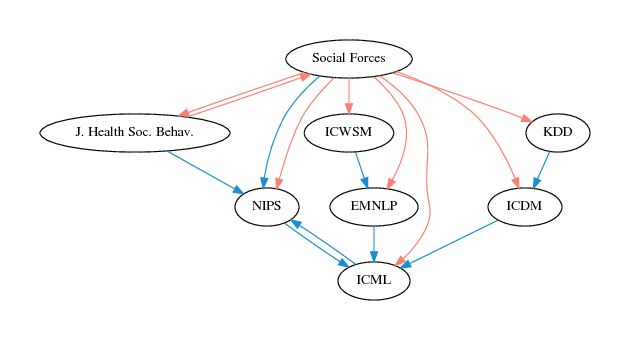

In [20]:
j1='American Sociological Review'
j2='Journal of Machine Learning Research'
targets = ['Knowledge Discovery and Data Mining', 'International Conference on Weblogs and Social Media']
expand_multi_seed(j1, j2, targets, 'ASR-JMLR-KDD-ICWSM.pdf')

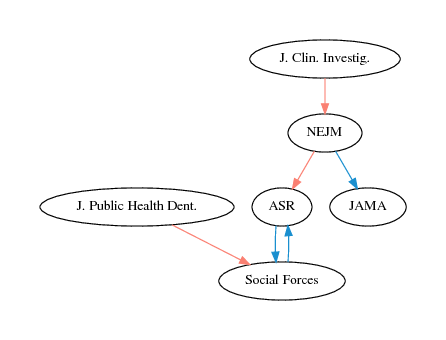

In [21]:
j1 = 'Cell'
j2 = 'Physical Review Letters'
expand_with_step(j1, j2, target = 'American Sociological Review', step=2)

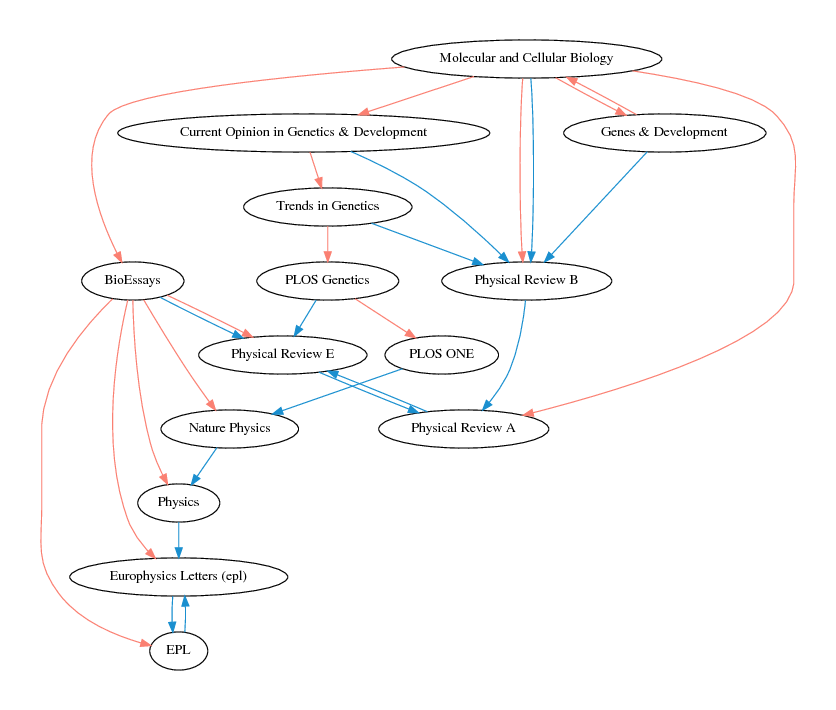

In [22]:
j1 = 'Cell'
j2 = 'Physical Review Letters'
expand(j1, j2, target = 'PLOS ONE', )

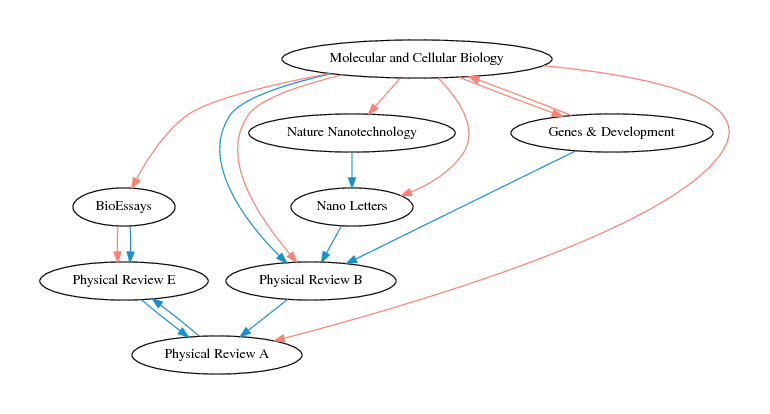

In [23]:
j1 = 'Cell'
j2 = 'Physical Review Letters'
expand(j1, j2, target = 'Nature Nanotechnology')

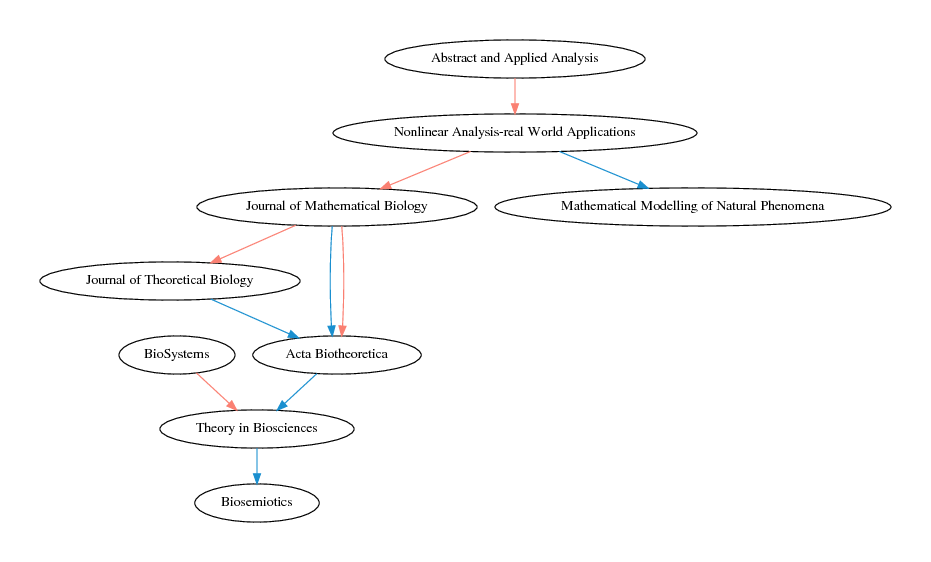

In [24]:
j1 = 'Applied Economics'
j2 = 'Theoretical Economics'
# expand(j1, j2, target = 'Research in Economics')
expand_with_step(j1, j2, target = 'Journal of Theoretical Biology', step = 3)

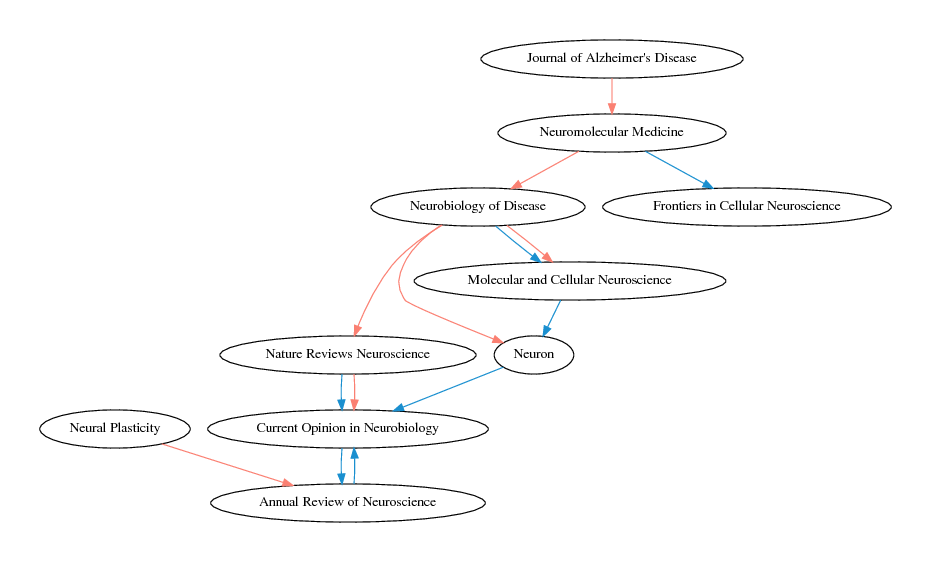

In [25]:
j1 = 'Applied Economics'
j2 = 'Theoretical Economics'
# expand(j1, j2, target = 'Research in Economics')
expand_with_step(j1, j2, target = 'Neuron', step = 3)

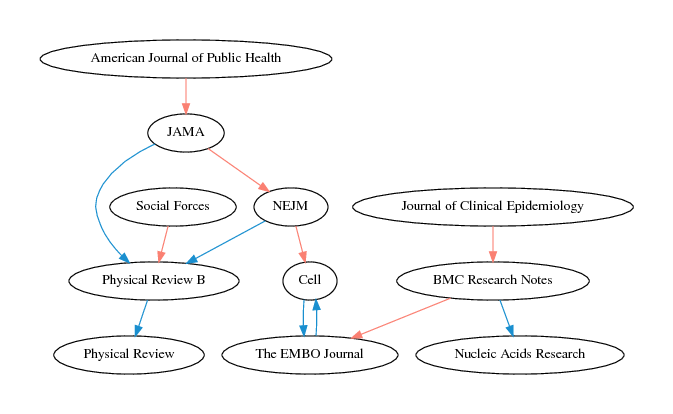

In [37]:
j1 = 'American Sociological Review'
j2 = 'Physical Review Letters'
expand_with_step(j1, j2, target = 'Cell', step = 3)

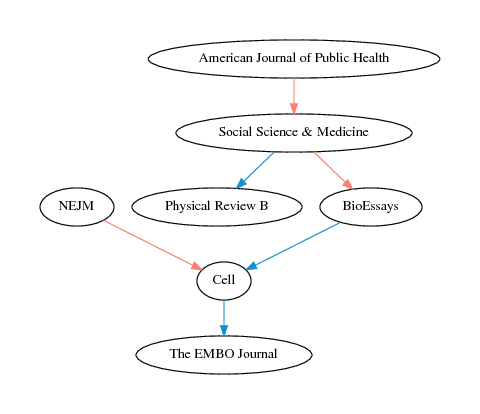

In [35]:
j1 = 'American Sociological Review'
j2 = 'Physical Review Letters'
expand_with_step(j1, j2, target = 'BioEssays', step = 2)

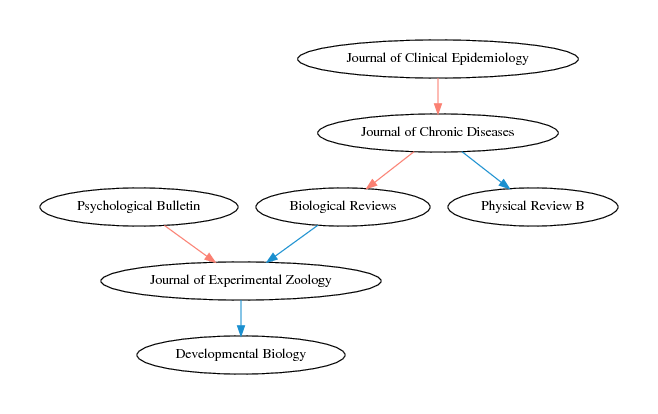

In [34]:
j1 = 'American Sociological Review'
j2 = 'Physical Review Letters'
expand_with_step(j1, j2, target = 'Biological Reviews', step = 2)

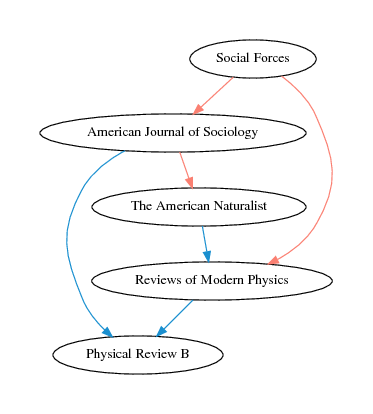

In [36]:
j1 = 'American Sociological Review'
j2 = 'Physical Review Letters'
expand_with_step(j1, j2, target = 'The American Naturalist', step = 2)